Here, we examine the sensitivity to a functional perturbation on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'
data = np.load(data_file)

# the observations
g_obs = np.array(data['g_obs'], dtype = int)

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# the ground truth 
true_ind_admix_propn = data['true_ind_admix_propn']

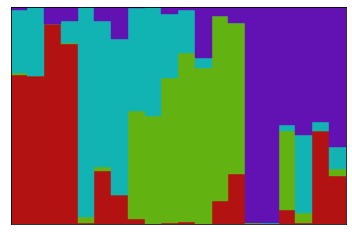

In [4]:
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

# Get prior

In [5]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [6]:
k_approx = 10

In [7]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [8]:
_, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                                      use_logitnormal_sticks = True)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 10, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (20, 9) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (20, 9) (lb=0.0001, ub=inf)


# Optimize

### Initialize with CAVI

In [9]:
vb_params_dict, cavi_init_time = \
            s_optim_lib.initialize_with_cavi(g_obs, 
                                 vb_params_paragami, 
                                 prior_params_dict, 
                                 gh_loc, gh_weights, 
                                 print_every = 20, 
                                 max_iter = 200, 
                                 seed = 1232)

Compiling cavi functions ...
CAVI compile time: 5.35sec

 running CAVI ...
iteration [20]; kl:1727.065955; elapsed: 0.182secs
iteration [40]; kl:1717.469716; elapsed: 0.1569secs
iteration [60]; kl:1716.170832; elapsed: 0.0747secs
iteration [80]; kl:1715.925407; elapsed: 0.0755secs
iteration [100]; kl:1715.87728; elapsed: 0.0749secs
iteration [120]; kl:1715.863515; elapsed: 0.0748secs
iteration [140]; kl:1715.858859; elapsed: 0.0749secs
iteration [160]; kl:1715.857204; elapsed: 0.0752secs
CAVI done.
final KL: 1715.856959
Elapsed: 166 steps in 0.81 seconds
Stick conversion time: 1.741secs


# Optimize with preconditioned LBFGS

In [10]:
vb_opt_dict, vb_opt, out, precond_objective, lbfgs_time = \
    s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                        vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc, gh_weights)

compiling preconditioned objective ... 
done. Elasped: 46.2428
init kl: 1719.067655
iteration [15]; kl:1718.946014; elapsed: 0.459secs
lbfgs converged successfully
done. Elapsed 2.1579


# Check out the fit

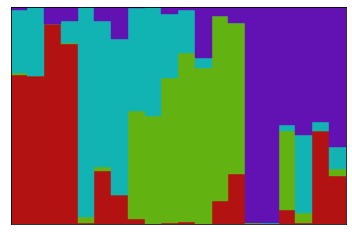

In [11]:
# truth
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

Text(0.5, 0, 'individual')

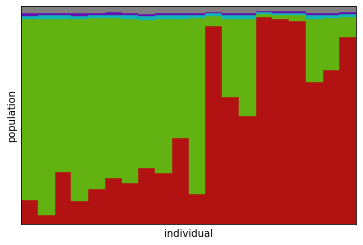

In [12]:
# estimated 

e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_top_clusters(e_ind_admix, axarr, n_top_clusters=4);

plt.ylabel('population')
plt.xlabel('individual')

# Set up linear response derivatives

In [13]:
# this is just a place holder for a null perturbation
# will set this properly later
hyper_par_objective_fun = lambda params, epsilon: 0.

In [14]:
# set up linear approximation class
epsilon0 = np.array([0.])

epsilon_sens = \
    HyperparameterSensitivityLinearApproximation(
        objective_fun = precond_objective.f, 
        opt_par_value = vb_opt, 
        hyper_par_value0 = epsilon0, 
        obj_fun_hvp = precond_objective.hvp, 
        hyper_par_objective_fun = hyper_par_objective_fun)


NOTE: using custom hvp
Compiling hessian solver ...
Hessian solver compile time: 94.1363sec

Compiling cross hessian...
Cross-hessian compile time: 0.0521724sec

LR sensitivity time: 0.026988sec



# Compute influence function

### Define posterior quantity of interest

In [15]:
def g(vb_free_params, vb_params_paragami): 
    
    # key for random sampling. 
    # this is fixed! so all standard normal 
    # samples used in computing the posterior quantity 
    key = jax.random.PRNGKey(0)
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                       key = key,
                                                       n_samples = 100)

In [16]:
get_grad_g = jax.jacobian(g, argnums = 0)
grad_g = get_grad_g(vb_opt, vb_params_paragami)

### the influence function

In [17]:
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           epsilon_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'ind_admix_params')

### worst-case perturbation

In [18]:
logit_v_grid = np.linspace(-10, 10, 200)
influence_grid = influence_operator.get_influence(logit_v_grid, grad_g)

In [19]:
worst_case_pert = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                      logit_v_grid = logit_v_grid, 
                                                      cached_influence_grid = influence_grid)

### Plot influence function

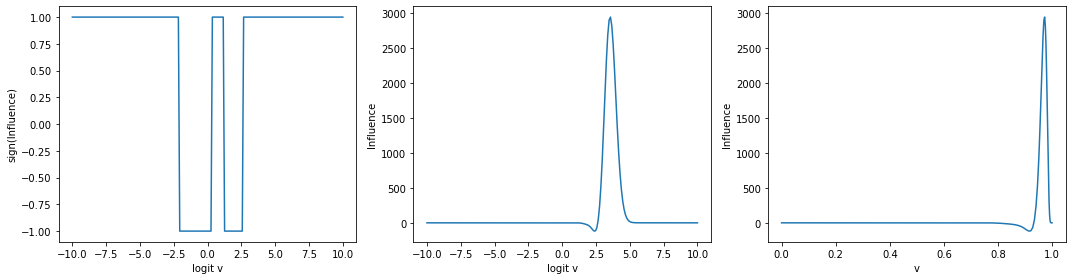

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 

ax[0].plot(worst_case_pert.logit_v_grid, np.sign(worst_case_pert.influence_grid))
ax[0].set_xlabel('logit v')
ax[0].set_ylabel('sign(Influence)')

ax[1].plot(worst_case_pert.logit_v_grid, worst_case_pert.influence_grid)
ax[1].set_xlabel('logit v')
ax[1].set_ylabel('Influence')

ax[2].plot(worst_case_pert.v_grid, worst_case_pert.influence_grid)
ax[2].set_xlabel('v')
ax[2].set_ylabel('Influence')


fig.tight_layout()

# Define prior perturbation

In [53]:
use_worst_case = True

In [54]:
if use_worst_case: 
    # just for plotting only! 
    # saves some time in computing the influence function
    # by doing a setp function interpolation
    def influence_fun_interp(logit_v): 
        # find index of logit_v_grid 
        # closest (on the left) to logit_v
        indx = np.searchsorted(worst_case_pert.logit_v_grid, logit_v)

        # return the influence function at those points
        return worst_case_pert.influence_grid[indx]

    # define log phi
    def log_phi(logit_v):
        return(np.sign(influence_fun_interp(logit_v)))
else: 
#     def log_phi(logit_v):
#         v = sp.special.expit(logit_v)
        
#         beta0 = prior_params_dict['dp_prior_alpha']
#         beta1 = beta0 + 5
        
#         return sp.stats.beta.logpdf(v, a = 1, b = beta1) - sp.stats.beta.logpdf(v, a = 1, b = beta0)
    
    def log_phi(logit_v): 
        return (sp.special.expit(-logit_v) * 2 - 1.) 

In [55]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.899219e-02
  warnings.warn(


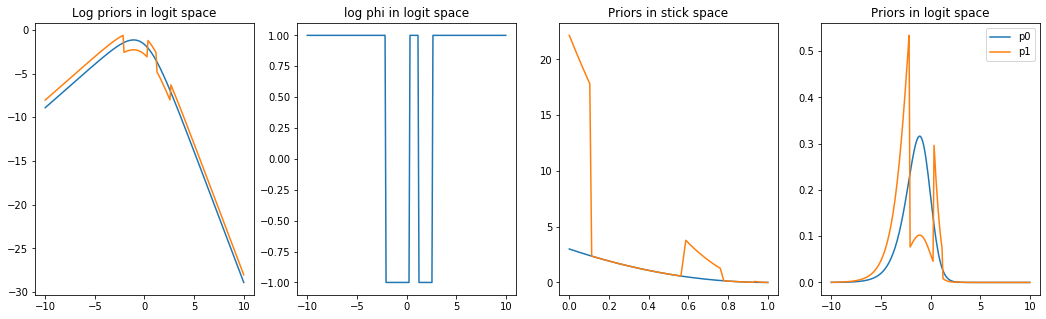

In [56]:
prior_perturbation.set_epsilon(1.0)

v_grid = sp.special.expit(logit_v_grid)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)),
            label = 'p0')
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)),
            label = 'p1')
plt.title('Priors in logit space')
plt.legend()


In [57]:
import bnpmodeling_runjingdev.exponential_families as ef

In [58]:
if use_worst_case: 
    print('returning worst case')
    fpert_obj = func_sens_lib.\
                    FunctionalPerturbationObjective(None, 
                                                     vb_params_paragami, 
                                                     gh_loc, 
                                                     gh_weights, 
                                                     e_log_phi = worst_case_pert.get_e_log_linf_perturbation, 
                                                     stick_key = 'ind_admix_params')
    
else: 
    fpert_obj = func_sens_lib.\
                    FunctionalPerturbationObjective(log_phi, 
                                                     vb_params_paragami, 
                                                     gh_loc, 
                                                     gh_weights, 
                                                     stick_key = 'ind_admix_params')

returning worst case


# Get derivative for prior perturbation

In [59]:
epsilon_sens._set_cross_hess_and_solve(fpert_obj.hyper_par_objective_fun)

Compiling cross hessian...
Cross-hessian compile time: 0.884048sec

LR sensitivity time: 0.0235558sec



In [60]:
epsilon = 1.0
print('Epsilon: ', epsilon)

lr_vb_free_params = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('init number of cluster: ', g(vb_opt, vb_params_paragami))
print('lr number of cluster: ', g(lr_vb_free_params, vb_params_paragami))

Epsilon:  1.0
init number of cluster:  2.9863734487798776
lr number of cluster:  2.397939139590507


In [61]:
vb_pert_pred_dict = vb_params_paragami.fold(lr_vb_free_params, free = True)

# Re-optimize

In [62]:
new_init_dict = deepcopy(vb_opt_dict)

In [63]:
vb_pert_dict, vb_opt_pert = \
    s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                                            new_init_dict,
                                            vb_params_paragami,
                                            prior_params_dict,
                                            gh_loc = gh_loc,
                                            gh_weights = gh_weights,
                                            e_log_phi = lambda means, infos : \
                                                           fpert_obj.e_log_phi_epsilon(means,
                                                                                       infos,
                                                                                       epsilon))[0:2]


compiling preconditioned objective ... 
done. Elasped: 46.561
init kl: 1785.504218
iteration [20]; kl:1709.151658; elapsed: 0.619secs
iteration [34]; kl:1706.741841; elapsed: 0.562secs
lbfgs converged successfully
done. Elapsed 1.7576


In [64]:
np.linalg.norm(vb_opt_pert - vb_opt)

DeviceArray(19.17893495, dtype=float64)

### compare

In [65]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot((lr_vb_free_params - vb_opt), 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


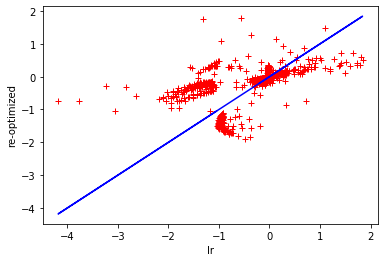

In [66]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [67]:
print('init number of cluster: ', g(vb_opt, vb_params_paragami))
print('pert number of cluster: ', g(vb_opt_pert, vb_params_paragami))
print('lr number of cluster: ', g(lr_vb_free_params, vb_params_paragami))

init number of cluster:  2.9863734487798776
pert number of cluster:  2.84100696779333
lr number of cluster:  2.397939139590507


# Fit for a range of epsilon

In [68]:
epsilon_list = np.linspace(0, 1, 8) ** 2 # Square to get more points close to 0
print(epsilon_list)

[0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [69]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum
    
    vb_opt = s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                                         new_init_dict,
                                        vb_params_paragami,
                                        prior_params_dict,
                                        gh_loc = gh_loc,
                                        gh_weights = gh_weights,
                                        e_log_phi = lambda means, infos : \
                                                           fpert_obj.e_log_phi_epsilon(means, infos, epsilon))[1]
        
    return vb_opt


In [70]:
print('epsilons: ', epsilon_list)

epsilons:  [0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [71]:
vb_pert_list = []
for epsilon in epsilon_list: 
    print('\n re-optimzing with epsilon = ', epsilon)
    
    vb_pert_list.append(refit_with_epsilon(epsilon, new_init_dict))



 re-optimzing with epsilon =  0.0
compiling preconditioned objective ... 
done. Elasped: 46.1274
init kl: 1718.946014
iteration [2]; kl:1718.946007; elapsed: 0.117secs
lbfgs converged successfully
done. Elapsed 0.678

 re-optimzing with epsilon =  0.02040816326530612
compiling preconditioned objective ... 
done. Elasped: 46.9203
init kl: 1720.304345
iteration [18]; kl:1720.265095; elapsed: 0.528secs
lbfgs converged successfully
done. Elapsed 1.0919

 re-optimzing with epsilon =  0.08163265306122448
compiling preconditioned objective ... 
done. Elasped: 46.3752
init kl: 1724.379337
iteration [20]; kl:1723.761791; elapsed: 0.607secs
iteration [22]; kl:1723.761783; elapsed: 0.110secs
lbfgs converged successfully
done. Elapsed 1.2822

 re-optimzing with epsilon =  0.18367346938775508
compiling preconditioned objective ... 
done. Elasped: 46.3292
init kl: 1731.170991
iteration [20]; kl:1728.120836; elapsed: 0.580secs
iteration [39]; kl:1728.112073; elapsed: 0.582secs
lbfgs converged succes

# Check free parameters

In [72]:
lr_list = []

for epsilon in epsilon_list: 
    
    # get linear response
    lr_list.append(epsilon_sens.predict_opt_par_from_hyper_par(epsilon))


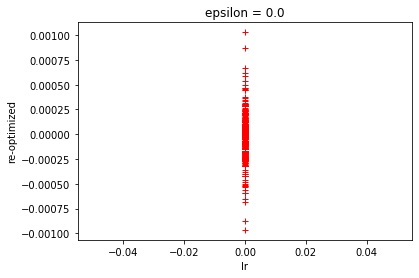

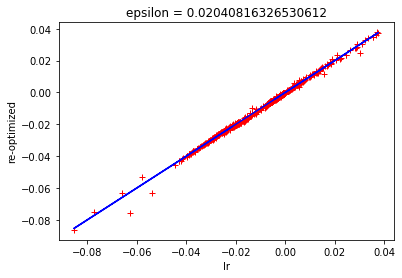

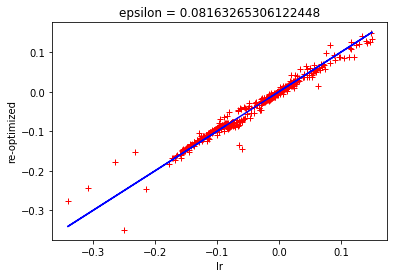

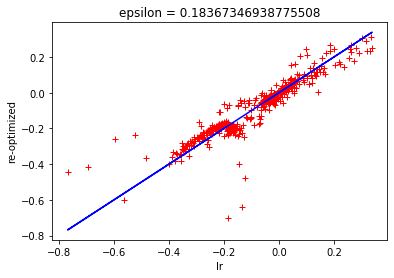

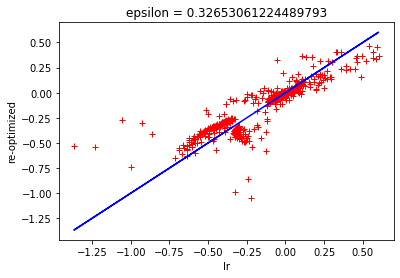

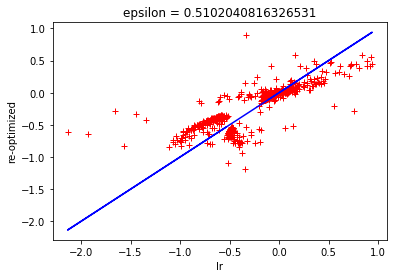

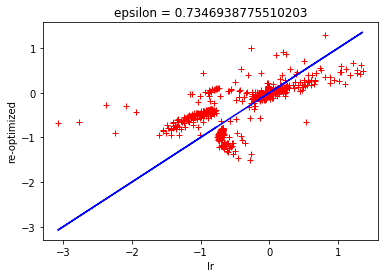

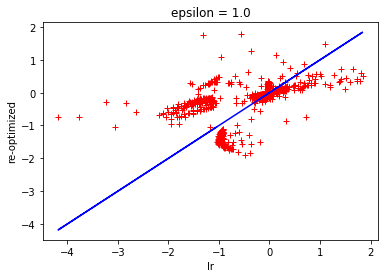

In [73]:
for i in range(len(epsilon_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('epsilon = {}'.format(epsilon_list[i]))


# Number of clusters

In [74]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_list))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_list))

for i in range(len(epsilon_list)): 
        
    # get number of clusters
    refit_e_num_clusters_vec[i] = g(vb_pert_list[i], vb_params_paragami)
    lr_e_num_clusters_vec[i] = g(lr_list[i], vb_params_paragami)


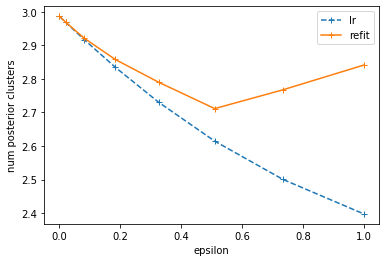

In [75]:
plt.plot(epsilon_list, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))
